This project aims to predict flight prices based on various features such as airline, source city, departure time, and more. The goal is to build an accurate regression model to help customers find the best deals or airlines optimize pricing strategies.

The trained model is integrated into a Streamlit app, allowing users to input flight details interactively and receive real-time price predictions. This app provides an intuitive interface for exploring how different factors, such as the number of stops or departure time, influence flight prices, making it a valuable tool for both travelers and airline companies.

In [1]:
import xgboost
print(xgboost.__version__)


1.7.6


In [2]:
# Import all libraries:
import os
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders import OneHotEncoder, TargetEncoder
from xgboost import XGBRegressor


# info

The dataset includes features such as airline, source city, departure time, stops, duration, and price. The number of observations are 300153. The target variable is the price of the flight. 

In [3]:
# Define the folder path at the root level
repo_root = os.path.dirname(os.getcwd())  # Moves one level up from `wine_model_notebooks`
data_folder = os.path.join(repo_root, 'DataSets')

# Ensure the DataSets folder exists at the root level
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Define file download details
file_id = '1hZwlOyubjj5RembXMu4a5BMoYmQBw5o_'
url = f'https://drive.google.com/uc?id={file_id}'
output = os.path.join(data_folder, 'Airline_Clean_Dataset.csv')

# Download and save file
gdown.download(url, output, quiet=False)

# Load the file
df = pd.read_csv(output)
print(df.head())

Downloading...
From: https://drive.google.com/uc?id=1hZwlOyubjj5RembXMu4a5BMoYmQBw5o_
To: /Users/yanellyhernandez/Desktop/Streamlit_Projects/DataSets/Airline_Clean_Dataset.csv
100%|██████████| 24.7M/24.7M [00:02<00:00, 10.9MB/s]


   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956  
3      Afternoon           Mumbai  Economy      2.25          1   5955  
4        Morning           Mumbai  Economy      2.33          1   5955  


## EDA

array([[<AxesSubplot: title={'center': 'Unnamed: 0'}>,
        <AxesSubplot: title={'center': 'duration'}>],
       [<AxesSubplot: title={'center': 'days_left'}>,
        <AxesSubplot: title={'center': 'price'}>]], dtype=object)

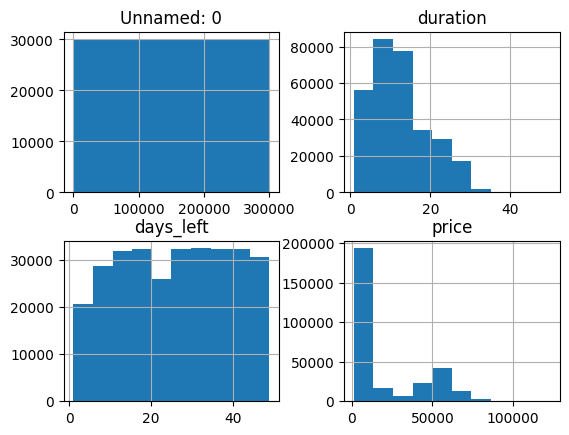

In [4]:
df.hist()

In [5]:
# Threshold for more than half nulls
threshold = len(df) / 2

# Find columns with more than half nulls
columns_with_many_nulls = df.columns[df.isnull().sum() > threshold]

print("Columns with more than half nulls:", columns_with_many_nulls.tolist())

Columns with more than half nulls: []


In [6]:
# Getting the correlated values:
corr_matrix = df.corr(numeric_only=True).abs()
# Getting the upper triangular matrix of the corr val:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


In [7]:
# Checking columns that have a high correlated value of 0.9.
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
to_drop

[]

In [8]:
# Looking at just the numerical features to fully understand how these feature effect SalePrice
numerical_features = df.select_dtypes(include=['float64', 'int64'])
# Compute the correlation matrix
correlation_matrix = numerical_features.corr()

# Find correlations
correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        correlations.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Print the results
for var1, var2, corr in correlations:
    print(f"{var1}, {var2}, {corr}")

duration, Unnamed: 0, 0.15900661568568858
days_left, Unnamed: 0, 0.014638430029270974
days_left, duration, -0.039156876605497125
price, Unnamed: 0, 0.7611771942560316
price, duration, 0.20422236784543787
price, days_left, -0.09194853217143521


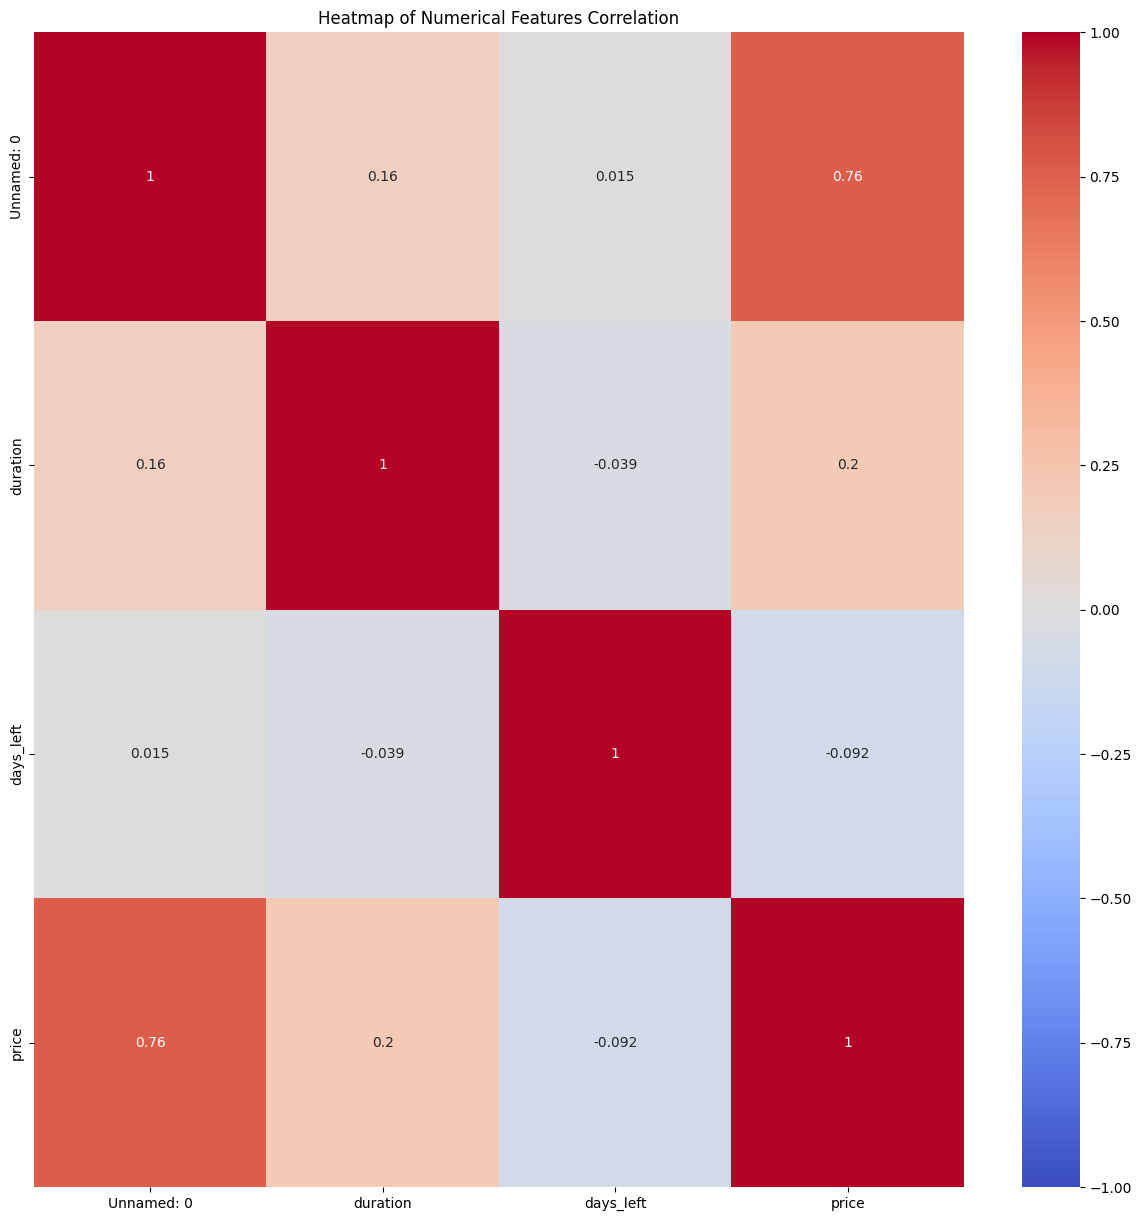

In [9]:
# Looking at just the numerical features to fully understand how these feature effect SalePrice
numerical_features = df.select_dtypes(include=['float64', 'int64'])
# Compute the correlation matrix
correlation_matrix = numerical_features.corr()
plt.figure(figsize=(15, 15))  # Adjust the figure size to make it more readable
sns.heatmap(correlation_matrix, annot=True, fmt='.2g', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Numerical Features Correlation')
plt.show()

Even though the only high correlated value is the column name Unnamed: 0 with price I decided to drop it since that column seem to be set as another form of indexing. Even though the other numerical features seem to have low correlations I kept them since these will be used as user inputs in my streamlit application. 

In [10]:
# Looking at just the categorical features
categorical_features = df.select_dtypes(include='object')
categorical_features 

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy
...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business


In [11]:
categorical_features['flight'].value_counts()

UK-706     3235
UK-772     2741
UK-720     2650
UK-836     2542
UK-822     2468
           ... 
SG-9923       1
6E-6474       1
6E-865        1
G8-705        1
G8-107        1
Name: flight, Length: 1561, dtype: int64

Since the feature 'flight' has multiple unique values I decided to drop it from the dataset since this is a user input based project. So I decided to not look at it any further. 

In [ ]:
categorical_features = ['airline', 'source_city', 'departure_time', 
                        'stops', 'arrival_time', 'destination_city', 'class']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=feature, y='price')
    plt.title(f'Flight Price Distribution by {feature.capitalize()}')
    plt.xticks(rotation=45)
    plt.show()



For the First Figure: Flight Price Distribution by Airline displays varying flight price ranges among different airlines. Vistara and Air India show broader price ranges, likely due to the premium services they offer, while SpiceJet and Indigo feature lower and more consistent price ranges, catering to budget-conscious travelers.

For the Second Figure: Flight Price Distribution by Source City highlights the presence of outliers for all source cities, with Delhi showing the highest number of outliers. However, the Interquartile Range (IQR) remains similar across all source cities, indicating comparable price distributions.

For the Third Figure: Flight Price Distribution by Departure Time demonstrates noticeable price fluctuations depending on the departure times. Night flights have a wider price range, likely reflecting the premium nature of these less frequent or high-demand slots. In contrast, late-night flights show consistently lower prices, potentially due to reduced demand. Morning, evening, and afternoon departures exhibit similar price ranges, suggesting competitive and steady pricing during these times.

For the Fourth Figure: Flight Price Distribution by Stops reveals wider price ranges and a higher maximum price (excluding outliers) in the one-stop category, while more outliers are present in the zero-stop and two-or-more-stop categories. The latter category seems to have more outliers spread out, possibly due to varying flight durations and distances.

For the Fifth Figure: Flight Price Distribution by Arrival Time shows narrower price ranges when the arrival time is early morning or late night, although there appear to be more outliers during these periods. This could be due to factors such as distance or other variables.

For the Second-to-Last Figure: Flight Price Distribution by Destination City shows that the price ranges across all cities appear similar in terms of the median, although there are more outliers in Delhi.

For the Last Figure: Flight Price Distribution by Class illustrates a stark contrast between Economy and Business class prices. Economy class features a smaller and more consistent price range, appealing to a broader audience, while Business class displays significantly higher median prices and a wider spread, reflecting its premium services and offerings.

## Dealing with selected features

In [12]:
df.drop(['Unnamed: 0', 'flight'], axis=1, inplace=True)
df

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   source_city       300153 non-null  object 
 2   departure_time    300153 non-null  object 
 3   stops             300153 non-null  object 
 4   arrival_time      300153 non-null  object 
 5   destination_city  300153 non-null  object 
 6   class             300153 non-null  object 
 7   duration          300153 non-null  float64
 8   days_left         300153 non-null  int64  
 9   price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 22.9+ MB


In [14]:
df.duplicated().sum()

2213

In [15]:
df['airline'].value_counts()

Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64

In [16]:
df['source_city']. value_counts()

Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: source_city, dtype: int64

In [17]:
df['departure_time'].value_counts()

Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: departure_time, dtype: int64

In [18]:
df['stops'].value_counts() # one hot

one            250863
zero            36004
two_or_more     13286
Name: stops, dtype: int64

In [19]:
df['arrival_time'].value_counts()

Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
Late_Night       14001
Name: arrival_time, dtype: int64

In [20]:
df['destination_city'].value_counts()

Mumbai       59097
Delhi        57360
Bangalore    51068
Kolkata      49534
Hyderabad    42726
Chennai      40368
Name: destination_city, dtype: int64

In [21]:
df['class'].value_counts() # one hot

Economy     206666
Business     93487
Name: class, dtype: int64

In [22]:
df['airline'].value_counts() # one hot

Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64

In [23]:
# Define categorical and numerical columns
categorical_columns_onehot = ['stops', 'class']
categorical_columns_target = ['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city']
numerical_columns_standard = ['duration', 'days_left']

# Splitting

In [24]:
X = df.drop(columns=['price'], axis= 1) 
y = df['price']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [26]:
X_train

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
203022,Indigo,Chennai,Morning,one,Evening,Hyderabad,Economy,8.83,7
163529,Vistara,Hyderabad,Afternoon,zero,Afternoon,Mumbai,Economy,1.58,36
212774,Air_India,Delhi,Evening,one,Morning,Bangalore,Business,17.17,12
178754,Indigo,Hyderabad,Afternoon,one,Evening,Chennai,Economy,5.08,30
30767,AirAsia,Delhi,Early_Morning,two_or_more,Afternoon,Hyderabad,Economy,8.42,18
...,...,...,...,...,...,...,...,...,...
21440,Indigo,Delhi,Afternoon,one,Evening,Kolkata,Economy,5.25,9
117583,Vistara,Bangalore,Evening,one,Morning,Chennai,Economy,15.92,26
73349,Indigo,Mumbai,Evening,one,Night,Hyderabad,Economy,5.67,23
267336,Air_India,Kolkata,Evening,one,Afternoon,Bangalore,Business,19.33,2


In [27]:
X_test

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
135562,Air_India,Kolkata,Night,one,Morning,Mumbai,Economy,13.67,49
95636,Indigo,Bangalore,Afternoon,one,Evening,Mumbai,Economy,6.08,11
65269,AirAsia,Mumbai,Night,one,Early_Morning,Kolkata,Economy,8.25,23
83129,Indigo,Mumbai,Morning,one,Evening,Chennai,Economy,5.08,43
257806,Vistara,Bangalore,Night,one,Morning,Hyderabad,Business,12.50,31
...,...,...,...,...,...,...,...,...,...
138129,Vistara,Kolkata,Morning,two_or_more,Night,Bangalore,Economy,12.42,20
81043,Indigo,Mumbai,Evening,one,Night,Chennai,Economy,5.08,28
257050,Vistara,Bangalore,Night,one,Evening,Hyderabad,Business,22.75,19
98125,Indigo,Bangalore,Afternoon,one,Evening,Mumbai,Economy,6.92,24


In [28]:
X_test.describe()

,duration,days_left
count,75039.000000,75039.000000
mean,12.194604,26.002252
std,7.188752,13.535735
min,0.830000,1.000000
25%,6.750000,15.000000
50%,11.250000,26.000000
75%,16.080000,38.000000
max,49.830000,49.000000


# build model

In [29]:
# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(cols=categorical_columns_onehot), categorical_columns_onehot),
        ('target', TargetEncoder(cols=categorical_columns_target), categorical_columns_target),
        ('standard', StandardScaler(), numerical_columns_standard)
    ])

# Create a pipeline with preprocessing and the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb_model', XGBRegressor(objective='reg:squarederror', tree_method='hist', gpu_id=-1))
])



In [30]:
print(X_train.columns)


Index(['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class', 'duration', 'days_left'],
      dtype='object')


In [31]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the pipeline
# Make predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

In [32]:
xgb_model = pipeline.named_steps['xgb_model']
print(xgb_model.get_params())


{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': -1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


# eval for over/underfit

In [33]:
# Evaluate the model
rmse_train =  mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test= mean_squared_error(y_test, y_test_pred, squared=False)



/Users/yanellyhernandez/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/yanellyhernandez/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
print(rmse_train)
print(rmse_test)

3461.3045130175956
3473.888862519938


In [35]:
def fit_test(rmse_train, rmse_test):
    ratio = rmse_train/rmse_test
    if ratio> 1:
        fit =  'underfit'
    else:
        fit = 'overfit'
    return (round(ratio, ndigits=2), fit)

In [36]:
fittest = fit_test(rmse_train, rmse_test)
fittest

(1.0, 'overfit')

# joblib

In [37]:
# If running in a Jupyter Notebook, use the current working directory or specify your base path
base_dir = os.getcwd()  # Get the current working directory

# Define the folder to save the pickled model
pickled_data_folder = os.path.join(base_dir, 'pickled_data')

# Make sure the directory exists, create it if it doesn't
os.makedirs(pickled_data_folder, exist_ok=True)


In [38]:
# Define the path where the model will be saved
model_save_path = os.path.join(pickled_data_folder, 'xgb_pipeline_Flight.pkl')

# Print the path to verify
print(f"Saving model at: {model_save_path}")

# Save the pipeline to the specified path
joblib.dump(pipeline, model_save_path)


Saving model at: /Users/yanellyhernandez/Desktop/Streamlit_Projects/Flight Model Notebooks/pickled_data/xgb_pipeline_Flight.pkl


['/Users/yanellyhernandez/Desktop/Streamlit_Projects/Flight Model Notebooks/pickled_data/xgb_pipeline_Flight.pkl']

In [39]:
# Save to a pickle file
eval_metrics = (rmse_train, rmse_test, fittest)
# Define the path where the evaluation metrics will be saved
eval_metrics_save_path = os.path.join(pickled_data_folder, 'Evaluation_Metrics_Flight.pkl')

# Create the eval_metrics tuple
eval_metrics = (rmse_train, rmse_test, fittest)

# Print the path to verify
print(f"Saving evaluation metrics at: {eval_metrics_save_path}")

# Save the evaluation metrics to the specified path
joblib.dump(eval_metrics, eval_metrics_save_path)

Saving evaluation metrics at: /Users/yanellyhernandez/Desktop/Streamlit_Projects/Flight Model Notebooks/pickled_data/Evaluation_Metrics_Flight.pkl


['/Users/yanellyhernandez/Desktop/Streamlit_Projects/Flight Model Notebooks/pickled_data/Evaluation_Metrics_Flight.pkl']